In [1]:
import pandas as pd
import numpy as np
import torch 
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tokenizers import Tokenizer

import pytorch_lightning as pl

from IPython.display import display
from typing import List, Dict, Any, Tuple
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from datasets import load_dataset

class ApeachDataset(Dataset):
    def __init__(self,
                 split: str,
                 tokenizer: Tokenizer, 
                 max_length: int = 256,
                 padding: str = "max_length") -> None:
        super().__init__()
        dataset = load_dataset("jason9693/APEACH")
        texts = dataset[split]['text']
        inputs = tokenizer(texts, padding=padding, max_length=max_length, truncation=True, return_tensors="pt")
        
        self.input_ids = inputs["input_ids"]
        self.attention_masks = inputs["attention_mask"]
        
        labels = dataset[split]['class']
        self.labels = torch.tensor(labels, dtype=torch.float32)
        
    def __len__(self):
        return self.input_ids.shape[0]
        
    def __getitem__(self, index: Any) -> Dict:
        return self.input_ids[index], self.attention_masks[index], self.labels[index]

    def dataloader(self, **kwargs) -> DataLoader:
        return DataLoader(self, **kwargs)


In [11]:
"""
monologg/koelectra-small-v3-discriminator
beomi/KcELECTRA-base
beomi/kcbert-base
beomi/kcbert-large
"""

huggingface_model_name = "monologg/koelectra-small-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(huggingface_model_name)

In [12]:
max_length = 64
batch_size = 128
labels = ['hate']
train_dl = ApeachDataset("train", tokenizer, max_length=max_length).dataloader(batch_size=batch_size)
val_dl = ApeachDataset("test", tokenizer, max_length=max_length).dataloader(batch_size=batch_size)

Using custom data configuration default-1815538999999b94
Reusing dataset csv (C:\Users\heegyukim\.cache\huggingface\datasets\csv\default-1815538999999b94\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 2/2 [00:00<00:00, 666.56it/s]
Using custom data configuration default-1815538999999b94
Reusing dataset csv (C:\Users\heegyukim\.cache\huggingface\datasets\csv\default-1815538999999b94\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 2/2 [00:00<00:00, 999.60it/s]


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics.functional as tm
from sklearn.metrics import multilabel_confusion_matrix
from transformers import BertForSequenceClassification, BertConfig


def join_step_outputs(outputs):
    result = {}
    keys = outputs[0].keys()
    for k in keys:
        X = [x[k] for x in outputs]
        if X[0].dim() == 0: # zero-dim tensor
            result[k] = torch.stack(X)
        else:
            result[k] = torch.cat(X, dim=0)
    return result

class TextClassificationModule(pl.LightningModule):
    def __init__(self, huggingface_model_name, labels, lr=5e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = AutoModelForSequenceClassification.from_pretrained(huggingface_model_name, num_labels=len(labels))
        # config = {
        #     "max_position_embeddings": 300,
        #     "hidden_dropout_prob": 0.1,
        #     "hidden_act": "gelu",
        #     "initializer_range": 0.02, # 12 to 2
        #     "num_hidden_layers": 2,
        #     "pooler_num_attention_heads": 12,
        #     "type_vocab_size": 2,
        #     "vocab_size": 30000,
        #     "hidden_size": 128, # 768 to 128
        #     "attention_probs_dropout_prob": 0.1,
        #     "num_attention_heads": 2, # 12 to 2
        #     "intermediate_size": 512, # 3072 to 512,
        #     "num_labels": len(labels)
        # }
        # self.model = BertForSequenceClassification(
        #     BertConfig(**config)
        # )
        self.multiclass = len(labels) > 1
        self.criterion = nn.CrossEntropyLoss() if self.multiclass else nn.BCELoss()
        self.labels = labels
            
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.lr)

    def forward(self, input_ids, attention_mask=None):
        logits = self.model(input_ids, attention_mask=attention_mask).logits
        if self.multiclass:
            logits = logits.softmax(dim=-1)
        else:
            logits = logits.sigmoid().squeeze(1).float()
        return logits

    def training_step(self, batch, batch_idx):
        ids, masks, labels = batch
        
        logits = self(ids, masks)
        loss = self.criterion(logits, labels)
        output = {"loss": loss, "logits": logits, "labels": labels}
        return output
    
    def training_epoch_end(self, outputs):
        outputs = join_step_outputs(outputs)
        loss = outputs["loss"].mean()
        self.log("train_epoch_loss", loss)

        logits = outputs["logits"]
        labels = outputs["labels"]
        acc = tm.accuracy(logits, labels.int())
        self.log(f"train_acc", acc, prog_bar=True)
        
    def validation_step(self, batch, batch_idx):
        ids, masks, labels = batch
        logits = self(ids, masks)
        loss = self.criterion(logits, labels)
        output = {"loss": loss, "logits": logits, "labels": labels}
        return output
    
    def validation_epoch_end(self, outputs):
        outputs = join_step_outputs(outputs)
        loss = outputs["loss"].mean()
        self.log("val_epoch_loss", loss, prog_bar=True)

        logits = outputs["logits"]
        labels = outputs["labels"]
        acc = tm.accuracy(logits, labels.int())
        self.log(f"val_acc", acc, prog_bar=True)



In [15]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
            
# val every n steps
# https://github.com/PyTorchLightning/pytorch-lightning/issues/2534

logger = pl.loggers.TensorBoardLogger(
    save_dir='.',
    name='lightning_logs'
)

save_dir = "./ckpt/"
checkpoint_callback = ModelCheckpoint(
    monitor="val_epoch_loss",
    dirpath=save_dir,
    filename=f"hate_{logger.version}_" + "{val_acc:.4f}",
    mode="min",
)

module = TextClassificationModule(
    huggingface_model_name,
    labels=labels,
    lr=1e-4
)
callbacks = [
    EarlyStopping("val_epoch_loss", mode="min", patience=10),
    checkpoint_callback
]

trainer = pl.Trainer(max_epochs=1000, 
                logger=logger,
                gpus=1 if torch.cuda.is_available() else 0,
                val_check_interval=20,
                callbacks=callbacks)
trainer.fit(module, train_dl, val_dl)

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

Epoch 4:  99%|█████████▊| 150/152 [02:40<00:02,  1.07s/it, loss=0.291, v_num=120, val_epoch_loss=0.677, val_acc=0.732, train_acc=0.881] 


In [13]:
checkpoint_callback.best_model_path
# module = TextClassificationModule.load_from_checkpoint(checkpoint_callback.best_model_path)

'C:\\Users\\heegyukim\\Desktop\\CurseFilter\\ckpt\\hate_116_val_acc=0.8122.ckpt'

In [27]:
preds = []
module.cuda().eval()
with torch.no_grad():
    for i in range(len(df)):
        text = df.text[i]
        x = tokenizer(text, return_tensors="pt")
        y = module(x['input_ids'].cuda())
        preds.append(y.cpu()[0].item())
df['preds'] = preds

<AxesSubplot:ylabel='Frequency'>

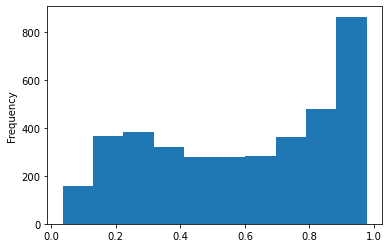

In [28]:
df.preds.plot.hist(bins=10)

In [29]:
df['pred_class'] = (df['preds'] > 0.5).astype(int)
error = df[df['class'] != df.pred_class]
error

,text,class,preds,pred_class
1,여자가 아이를 돌보고 남자가 밖에서 돈을 벌어온다' 다 옛날 말이죠. 요즘은 다 반...,0,0.623334,1
5,1개월차가 의견 내는 건 안받아 주나봐.,0,0.508775,1
20,감성 메마른 문과생,0,0.638793,1
28,같은 성별에 사람이 만난다고 하니 놀라운가봐.,0,0.613181,1
29,개나 소나 다 대학 갈 필요는 없지. 노래 잘하고 돈 잘벌고 곡도 잘 쓰는데 왜 꼭...,0,0.604390,1
...,...,...,...,...
3705,채식주의자들은 너무 피곤하게 굴어.,1,0.260329,0
3707,남자면 그냥 해도 될텐데 고집을 많이 부리네요. 불편해도 좀 참아야 다들 편한데,1,0.440287,0
3719,확실히 서울하고 경상도 사람은 차이가 있어요. 일하는데 드문드문 이상하다 싶으면 여...,1,0.357368,0
3729,한국인은 동방예의지국이니까 장유유서를 지키고 차례를 지켜서 밥을 먹는게 당연하지 ...,1,0.405372,0
